## Importing Libraries

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping
import datetime
from keras import regularizers
import matplotlib.pyplot as plt
from keras.utils.vis_utils import plot_model
import seaborn as sn

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Exploring Dataset

In [3]:
train_dir = '/content/drive/MyDrive/colab/fer2013/train/'
test_dir = '/content/drive/MyDrive/colab/fer2013/test/'

row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       angry  disgust  fear  happy  neutral   sad  surprise
train   3995      436  4097   7215     4965  4830      3171
      angry  disgust  fear  happy  neutral   sad  surprise
test    958      111  1024   1774     1233  1247       831


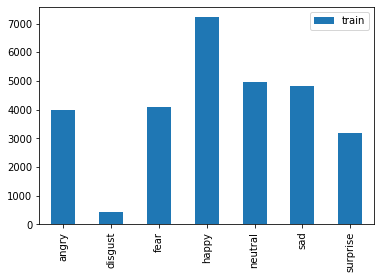

In [5]:
train_count = train_count.transpose().plot(kind='bar')

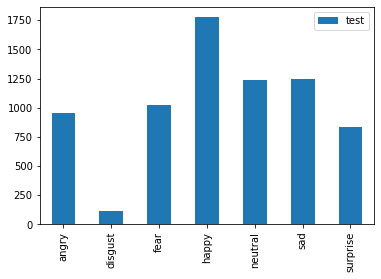

In [7]:
test_count.transpose().plot(kind='bar')

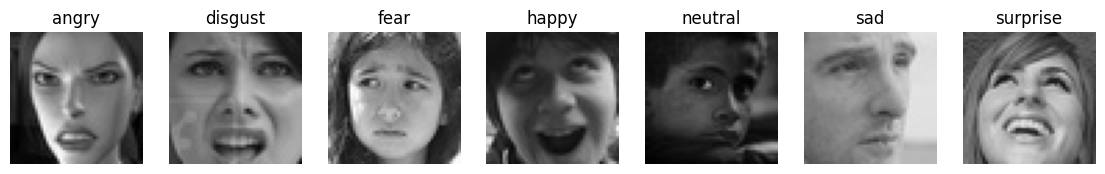

In [26]:
gallery = plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[5]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

## Creating train test and validation datasets

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True,
                                   validation_split=0.2)

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical',
                                                subset='training')
validation_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical',
                                                subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255,
                                   horizontal_flip=True)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
# labels 
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

## Model Architecture

In [11]:
weight_decay = 1e-4

num_classes = 7

model = tf.keras.models.Sequential()

model.add(Conv2D(64, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=(48,48,1)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
 
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))
 
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (4,4), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(128, activation="linear"))
model.add(Activation('elu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(0.0003), metrics=['accuracy'])
 
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        1088      
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        65600     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                        

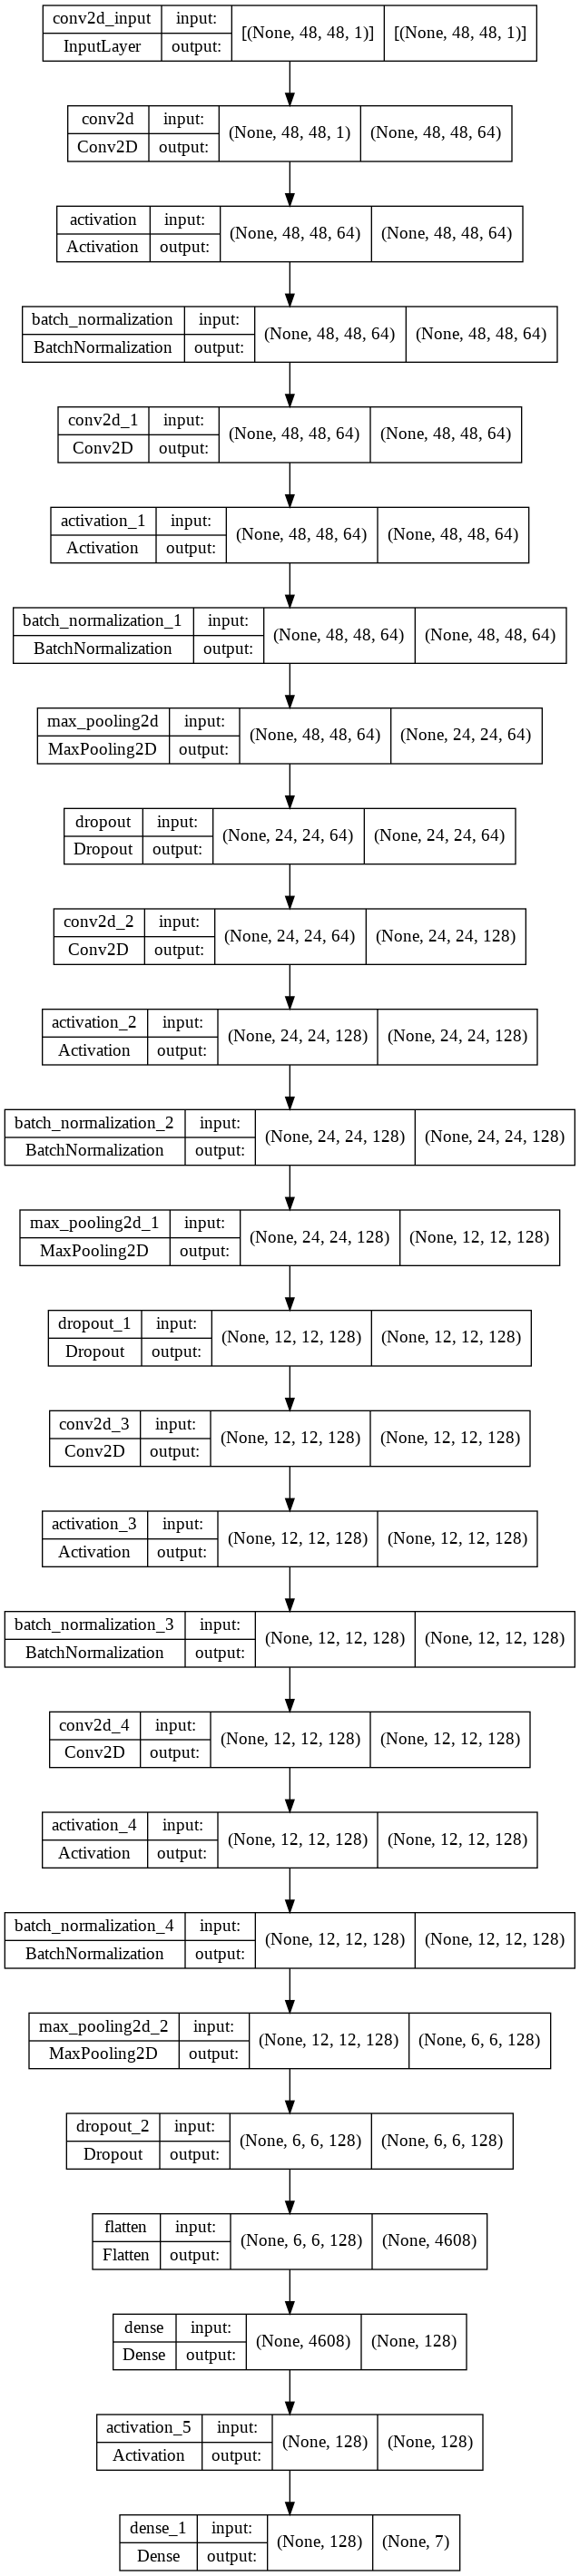

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [12]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', verbose = 1, restore_best_weights=True,mode="max",patience = 10),
                ModelCheckpoint(
                    filepath='model.weights.best.hdf5',
                    monitor="val_accuracy",
                    verbose=1,
                    save_best_only=True,
                    mode="max")]

## Model Training

In [13]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [14]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = validation_set.n // validation_set.batch_size

history = model.fit(x=training_set,
                 validation_data=validation_set,
                 epochs=200,
                 callbacks=[checkpointer],
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/200
358/358 [==============================] - ETA: 0s - loss: 1.8279 - accuracy: 0.3202
Epoch 1: val_accuracy improved from -inf to 0.33673, saving model to model.weights.best.hdf5
358/358 [==============================] - 64s 141ms/step - loss: 1.8279 - accuracy: 0.3202 - val_loss: 1.8419 - val_accuracy: 0.3367
Epoch 2/200
358/358 [==============================] - ETA: 0s - loss: 1.5529 - accuracy: 0.4118
Epoch 2: val_accuracy improved from 0.33673 to 0.44364, saving model to model.weights.best.hdf5
358/358 [==============================] - 42s 117ms/step - loss: 1.5529 - accuracy: 0.4118 - val_loss: 1.4637 - val_accuracy: 0.4436
Epoch 3/200
358/358 [==============================] - ETA: 0s - loss: 1.4217 - accuracy: 0.4706
Epoch 3: val_accuracy did not improve from 0.44364
358/358 [==============================] - 41s 113ms/step - loss: 1.4217 - accuracy: 0.4706 - val_loss: 1.5716 - val_accuracy: 0.4243
Epoch 4/200
358/358 [==============================] - ETA: 0s - lo

In [102]:
model.save('/content/drive/MyDrive/colab/emotion_model.h5')

##Load Saved Model

In [6]:
from tensorflow.keras.models import load_model

In [7]:
model = load_model('/content/drive/MyDrive/colab/emotion_model.h5')

## Model Performance

In [ ]:
training_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.rcParams['figure.figsize'] = [10, 5]
plt.style.use(['default'])
# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.legend(['Training Loss', 'Val Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

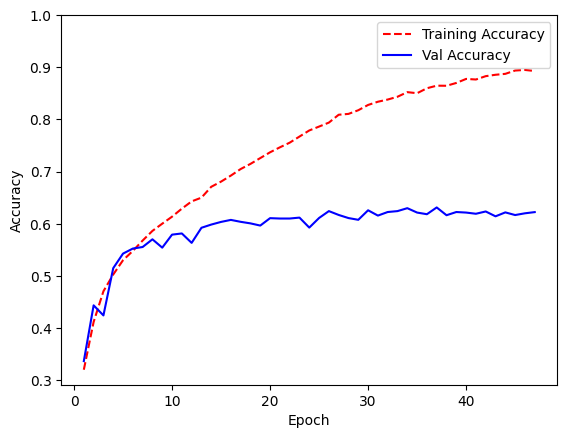

In [19]:
training_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history

plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, val_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(top = 1)
plt.show()

In [ ]:
# saving the model
model.save("fer_model.h5")

## Test Accuracy

In [ ]:
print(f"Test accuracy = {model.evaluate(test_set ,batch_size=test_set.batch_size,steps=test_set.n // test_set.batch_size)[1]*100}%")

## Confusion Matrix

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import pandas as pd

In [11]:
class_labels={'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

### Confusion matrix on Training Set

In [12]:
y_pred_train = model.predict(training_set)
y_pred_train= np.argmax(y_pred_train, axis=1)
#class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred_train)
print('Confusion Matrix')
print(cm_train)


Confusion Matrix
[[ 432   50  442  807  578  545  342]
 [  47    8   54   89   50   57   44]
 [ 462   42  425  850  580  542  377]
 [ 817   95  752 1433 1056  958  661]
 [ 524   62  558  994  741  657  436]
 [ 534   52  579 1003  661  611  424]
 [ 351   40  351  660  478  412  245]]


Classification Report
              precision    recall  f1-score   support

           0       0.14      0.14      0.14      3196
           1       0.02      0.02      0.02       349
           2       0.13      0.13      0.13      3278
           3       0.25      0.25      0.25      5772
           4       0.18      0.19      0.18      3972
           5       0.16      0.16      0.16      3864
           6       0.10      0.10      0.10      2537

    accuracy                           0.17     22968
   macro avg       0.14      0.14      0.14     22968
weighted avg       0.17      0.17      0.17     22968



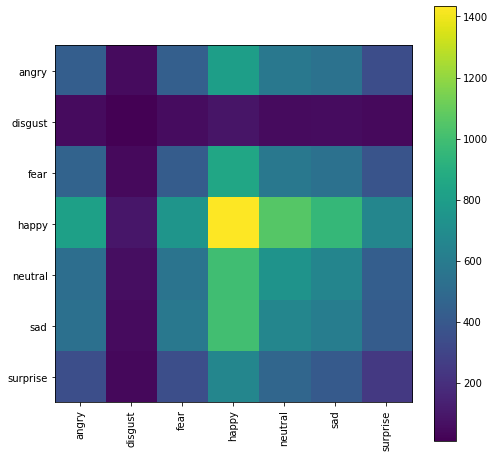

In [14]:
print('Classification Report')
target_names = list(class_labels.values())
clf_train =classification_report(training_set.classes, y_pred_train)#, target_names=target_names))
print(clf_train)
plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

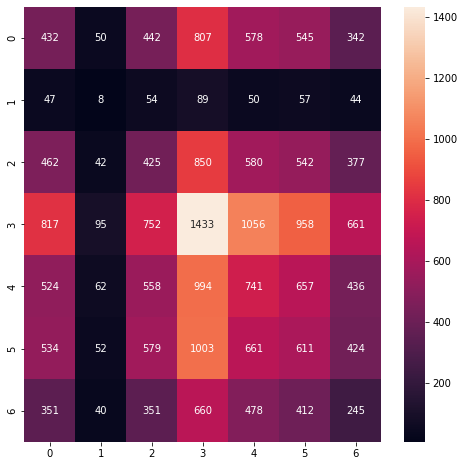

In [19]:
plt.figure(figsize=(8,8))
sn.heatmap(cm_train, annot=True,fmt="")

### Confusion Matrix on Validation Dataset

Confusion Matrix
[[126   8  90 203 151 139  82]
 [ 13   2  12  16  17  15  12]
 [103  15 110 222 144 144  81]
 [189  19 172 371 295 229 168]
 [145  12 120 280 182 163  91]
 [134  17 112 266 197 138 102]
 [ 83   6  82 155 139 102  67]]
Classification Report
              precision    recall  f1-score   support

           0       0.16      0.16      0.16       799
           1       0.03      0.02      0.02        87
           2       0.16      0.13      0.15       819
           3       0.25      0.26      0.25      1443
           4       0.16      0.18      0.17       993
           5       0.15      0.14      0.15       966
           6       0.11      0.11      0.11       634

    accuracy                           0.17      5741
   macro avg       0.14      0.14      0.14      5741
weighted avg       0.17      0.17      0.17      5741



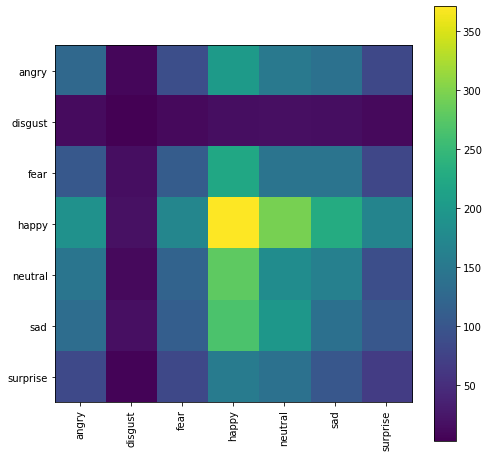

In [20]:
y_pred_val = model.predict(validation_set)
y_pred_val = np.argmax(y_pred_val, axis=1)
cm_val = confusion_matrix(validation_set.classes, y_pred_val)
print('Confusion Matrix')
print(cm_val)
print('Classification Report')
target_names = list(class_labels.values())
clf_val=classification_report(validation_set.classes, y_pred_val)#, target_names=target_names))
print(clf_val)
plt.figure(figsize=(8,8))
plt.imshow(cm_val, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

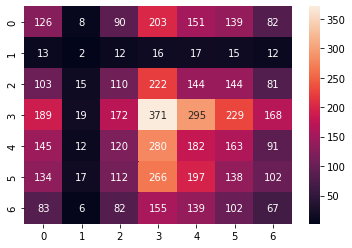

In [21]:
sn.heatmap(cm_val, annot=True,fmt="")

## Confusion Matrix on Test Dataset

Confusion Matrix
[[117  17 113 263 183 153 112]
 [ 15   0  13  28  27  14  14]
 [141  13 123 262 196 164 125]
 [213  16 204 451 374 321 195]
 [184  16 129 334 231 222 117]
 [167  15 141 326 257 202 139]
 [123   6 109 205 159 132  97]]
Classification Report
              precision    recall  f1-score   support

           0       0.12      0.12      0.12       958
           1       0.00      0.00      0.00       111
           2       0.15      0.12      0.13      1024
           3       0.24      0.25      0.25      1774
           4       0.16      0.19      0.17      1233
           5       0.17      0.16      0.16      1247
           6       0.12      0.12      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



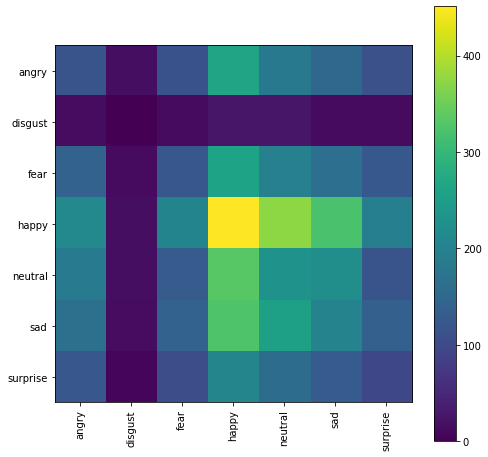

In [22]:
y_pred_test = model.predict(test_set)
y_pred_test = np.argmax(y_pred_test, axis=1)

cm_test = confusion_matrix(test_set.classes, y_pred_test)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
clf_test=classification_report(test_set.classes, y_pred_test)#, target_names=target_names))
print(clf_test)
plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

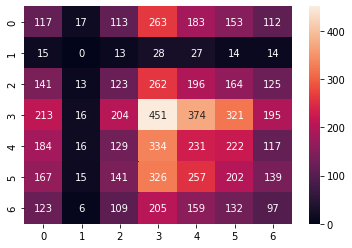

In [23]:
sn.heatmap(cm_test, annot=True,fmt="")

## Plotting Predictions

In [52]:
# next function assigns one batch to variables, i.e x_test,y_test will have 64 images
x_test,y_test = next(test_set)
predict = model.predict(x_test)

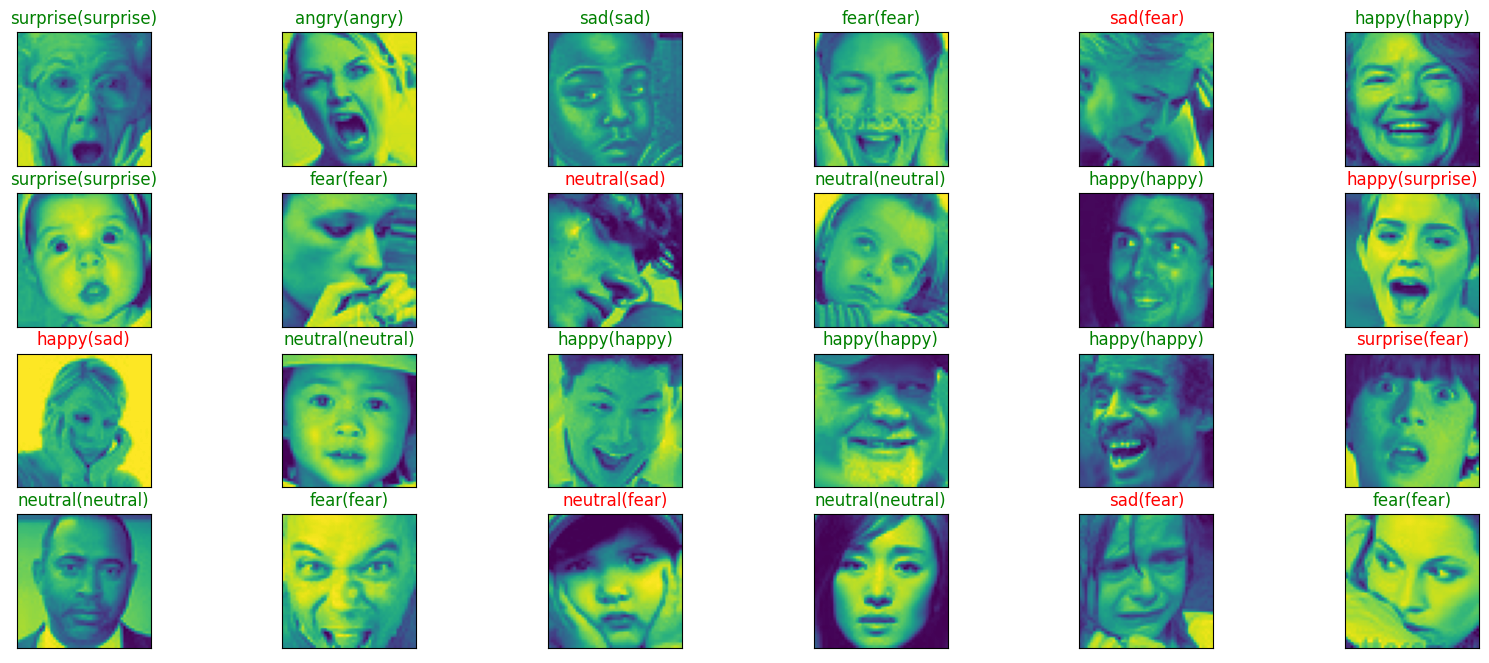

In [83]:
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = class_labels[(np.argmax(predict[index]))]
    true_index = class_labels[(np.argmax(y_test[index]))]
    
    ax.set_title("{}({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

In [57]:
np.array(x_test[0]).shape

(48, 48, 1)

In [59]:
import cv2

In [67]:
clin = cv2.imread('/content/clinton.png')

In [68]:
clin = cv2.cvtColor(clin, cv2.COLOR_BGR2GRAY)

In [69]:
newimg = cv2.resize(clin,(48,48))
newimg = np.array([el/255.0 for el in newimg])
pred = model.predict(newimg.reshape(1,48, 48, 1))

In [72]:
class_labels

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [74]:
np.argmax(pred)

3

In [76]:
class_labels[np.argmax(pred)]

'happy'